# Diabetic Retinopathy Classifier
#### Author: Sean Flannery [sflanner@purdue.edu](sflanner@purdue.edu)
Last updated: April 22, 2019

## Data Acquisition

This portion of work was partially inspired by the useful resources found at this tutorial: [https://machinelearningmastery.com/how-to-load-convert-and-save-images-with-the-keras-api/](https://machinelearningmastery.com/how-to-load-convert-and-save-images-with-the-keras-api/)

In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
np.random.seed(42)

We need to import the necessary preprocessing functions to convert our image to a numpy array quickly.

In [3]:
from keras.preprocessing.image import load_img, save_img
from keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image

Originally, these are immensely high-quality images. However, we have limited resources on a laptop, and thus are gonna shrink them down to size a bit.

In [4]:
DESIRED_WIDTH = 224 #Change back to 224
DESIRED_HEIGHT = 224

In [5]:
def resizeImg(filename):
    new_width = DESIRED_WIDTH
    new_height = DESIRED_HEIGHT
    img = Image.open(filename)
    img = img.resize((new_width,new_height), Image.ANTIALIAS)
    return img

We want to navigate over the raw images we've been given of retinal scans, and put them somewhere more accessible.

In [6]:
def convertTrainImgToNumpy(file_id):
    file = os.getcwd() + '/original-images-disease-grades/train/'
    file += 'IDRiD_' + str(file_id + 1000)[1:] + '.jpg' 
    return img_to_array(resizeImg(file))
def convertTestImgToNumpy(file_id):
    file = os.getcwd() + '/original-images-disease-grades/test/'
    file += 'IDRiD_' + str(file_id + 1000)[1:] + '.jpg' 
    return img_to_array(resizeImg(file))

As an example, let's look at a resized image.

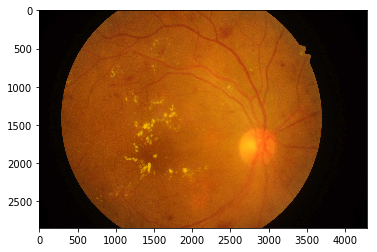

In [7]:
filename = os.getcwd() + '/original-images-disease-grades/train/IDRiD_001.jpg'
img = Image.open(filename)
plt.imshow(img)

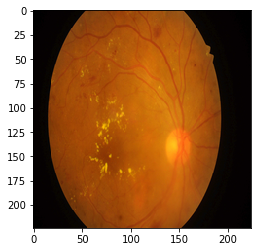

In [8]:
img = resizeImg(filename)
plt.imshow(img)

In order to speed up our analysis, we will also import the multiprocessing packages of Python to enable simultaneous analysis. We will also include tqdm to enable us to track the progress of parsing data.

In [9]:
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

In [10]:
entry_range = list(range(1,414,1))
with Pool(20) as p:
    train_list = list(tqdm(p.imap(convertTrainImgToNumpy, entry_range), total=len(entry_range)))

In [11]:
entry_range = list(range(1,104,1))
with Pool(20) as p:
    test_list = list(tqdm(p.imap(convertTestImgToNumpy, entry_range), total=len(entry_range)))

Now, we are interested in storing our images for later pre-processing in the Part 1 notebook! We shall save them in the part1 folder as `xtrain.npy` and `xtest.npy`. 

In [12]:
xtrain_file = os.getcwd() + '/part1/x_train.npy'
train_np = np.array(train_list, 'float32')
np.save(xtrain_file, train_np)

In [13]:
xtest_file = os.getcwd() + '/part1/x_test.npy'
test_np = np.array(test_list, 'float32')
np.save(xtest_file, test_np)

Now, we want to save our y-values from groundtruths as well.

In [14]:
y_train_data = np.genfromtxt(os.getcwd() + '/original-images-disease-grades/groundtruths/training_labels.csv', delimiter=',', skip_header=1, encoding='utf-8')
y_train = np.array(y_train_data[:, [1,2]], dtype='int32')
ytrain_file = os.getcwd() + '/part1/y_train.npy'
np.save(ytrain_file, y_train)

In [15]:
y_test_data = np.genfromtxt(os.getcwd() + '/original-images-disease-grades/groundtruths/test_labels.csv', delimiter=',', skip_header=1, encoding='utf-8')
y_test = np.array(y_test_data[:, [1,2]], dtype='int32')
ytest_file = os.getcwd() + '/part1/y_test.npy'
np.save(ytest_file, y_test)

## Image Preprocessing & Data Augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

In our use case, we are only interested in the first column (diabetic retinopathy) and not the muscular edeme component.

In [17]:
def load_np_data():
    x_train = np.load('part1/x_train.npy')
    y_train = np.load('part1/y_train.npy')[:,0]
    x_test = np.load('part1/x_test.npy')
    y_test = np.load('part1/y_test.npy')[:,0]
    return (x_train, y_train), (x_test, y_test)

In [18]:
(x_train, y_train), (x_test, y_test) = load_np_data()

Now, we want to convert our y-values to categorical values.

In [19]:
num_classes = 5 # scale of diabetic retinopathy
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

We will use the built-in Keras `ImageDataGenerator` to great effect, as it does a significant amount of the preprocessing for us. 

This will also generate more data from our relatively limited dataset.

In [20]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.255)

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    rotation_range=40,     # randomly rotate pictures
    width_shift_range=0.1, # randomly translate pictures
    height_shift_range=0.1, 
    shear_range=0.2,       # randomly apply shearing
    zoom_range=0.2,        # random zoom range
    horizontal_flip=True)  # randomly flip image

In [22]:
train_datagen.fit(x_train)

In [23]:
test_datagen.fit(x_test)

In [24]:
batch_size = 32

In [25]:
train_generator = train_datagen.flow(x_train, y_train, 
                                     batch_size=batch_size)

In [26]:
validation_generator = test_datagen.flow(x_test, y_test, 
                                         batch_size=batch_size)

## Model Creation
We will now use the Keras Sequential API to create a suitable Convolutional Neural Network. We will initially use the structure of ResNet50 for our network (partially inspired by [this](https://www.kaggle.com/cokastefan/keras-resnet-50) great kaggle kernel.

In [27]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization

First, we will include the lightweight (but surprisingly accurate) ResNet50 for transfer learning. We will take advantage of the features it has already managed to discover in other images and apply them to our dataset.

In [28]:
model = Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', input_shape=(DESIRED_WIDTH,DESIRED_HEIGHT,3)))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Since ResNet50 already includes the convolutional layers, we pass the final **4D Tensor Layer** to a **Flattener** and then pass it to some Dense (AKA **fully-connected**) layers in keras with normalization per individual batch and aggressive **dropout** to prevent overfitting.

We use the "rectified linear unit" or **relu** activation function here.

In [29]:
model.add(Flatten())
model.add(Dense(1280))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1280))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(640))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Finally, we use the **softmax** activation function, because we want to choose the category with highest likelihood and softmax ensures this for us.

In [30]:
model.add(Dense(num_classes, activation='softmax'))

We use an especially small learning rate to prevent overfitting on spurious features from the original ResNet50 distributions.

In [31]:
adam = keras.optimizers.Adam(lr=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Now that we've compiled our model successfully, let's take a look at how many parameters we'll be working with and analyze our model structure.

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              128451840 
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
activation_50 (Activation)   (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1280)              1639680   
__________

## Train our Model
Now, we will bring everything together and actually train on our augmented dataset, saving the best version of the network as we go along!

In [33]:
from keras.callbacks import ModelCheckpoint
filepath = "resnet50-weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
callbacks_list = [checkpoint]

In [34]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(x_train) // batch_size,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=len(x_test) // batch_size,
        callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
12/12 [==============================] - 225s 19s/step - loss: 2.7084 - acc: 0.1797 - val_loss: 1.6718 - val_acc: 0.1979

Epoch 00001: val_acc improved from -inf to 0.19792, saving model to resnet50-weights-improvement.hdf5
Epoch 2/200
12/12 [==============================] - 220s 18s/step - loss: 2.5701 - acc: 0.2123 - val_loss: 1.5646 - val_acc: 0.2254

Epoch 00002: val_acc improved from 0.19792 to 0.22535, saving model to resnet50-weights-improvement.hdf5
Epoch 3/200
12/12 [==============================] - 223s 19s/step - loss: 2.5866 - acc: 0.2087 - val_loss: 1.6124 - val_acc: 0.2254

Epoch 00003: val_acc did not improve from 0.22535
Epoch 4/200
12/12 [==============================] - 199s 17s/step - loss: 2.4874 - acc: 0.2152 - val_loss: 1.4885 - val_acc: 0.3380

Epoch 00004: val_acc improved from 0.22535 to 0.33803, saving model to resnet50-weights-improvement.hdf5
Epoch 5/200
12/12 [==============================] - 2

12/12 [==============================] - 200s 17s/step - loss: 1.4208 - acc: 0.4792 - val_loss: 1.3621 - val_acc: 0.4507

Epoch 00040: val_acc did not improve from 0.54930
Epoch 41/200
12/12 [==============================] - 201s 17s/step - loss: 1.5161 - acc: 0.4446 - val_loss: 1.3061 - val_acc: 0.5104

Epoch 00041: val_acc did not improve from 0.54930
Epoch 42/200
12/12 [==============================] - 198s 17s/step - loss: 1.3210 - acc: 0.4993 - val_loss: 1.2567 - val_acc: 0.5211

Epoch 00042: val_acc did not improve from 0.54930
Epoch 43/200
12/12 [==============================] - 198s 17s/step - loss: 1.4922 - acc: 0.4550 - val_loss: 1.6524 - val_acc: 0.4225

Epoch 00043: val_acc did not improve from 0.54930
Epoch 44/200
12/12 [==============================] - 198s 16s/step - loss: 1.4177 - acc: 0.4668 - val_loss: 1.0384 - val_acc: 0.5493

Epoch 00044: val_acc did not improve from 0.54930
Epoch 45/200
12/12 [==============================] - 201s 17s/step - loss: 1.4028 - acc

12/12 [==============================] - 196s 16s/step - loss: 1.0138 - acc: 0.6062 - val_loss: 1.5425 - val_acc: 0.4507

Epoch 00084: val_acc did not improve from 0.57746
Epoch 85/200
12/12 [==============================] - 199s 17s/step - loss: 1.0676 - acc: 0.6114 - val_loss: 1.2617 - val_acc: 0.5104

Epoch 00085: val_acc did not improve from 0.57746
Epoch 86/200
12/12 [==============================] - 196s 16s/step - loss: 0.9143 - acc: 0.6424 - val_loss: 1.4214 - val_acc: 0.5493

Epoch 00086: val_acc did not improve from 0.57746
Epoch 87/200
12/12 [==============================] - 196s 16s/step - loss: 0.9461 - acc: 0.6353 - val_loss: 1.6010 - val_acc: 0.4648

Epoch 00087: val_acc did not improve from 0.57746
Epoch 88/200
12/12 [==============================] - 196s 16s/step - loss: 1.0146 - acc: 0.6431 - val_loss: 1.2204 - val_acc: 0.4930

Epoch 00088: val_acc did not improve from 0.57746
Epoch 89/200
12/12 [==============================] - 198s 17s/step - loss: 0.9478 - acc

12/12 [==============================] - 198s 17s/step - loss: 0.5853 - acc: 0.7559 - val_loss: 1.5525 - val_acc: 0.5211

Epoch 00128: val_acc did not improve from 0.59155
Epoch 129/200
12/12 [==============================] - 201s 17s/step - loss: 0.6404 - acc: 0.7474 - val_loss: 1.4057 - val_acc: 0.5521

Epoch 00129: val_acc did not improve from 0.59155
Epoch 130/200
12/12 [==============================] - 198s 17s/step - loss: 0.7109 - acc: 0.7244 - val_loss: 1.1319 - val_acc: 0.5775

Epoch 00130: val_acc did not improve from 0.59155
Epoch 131/200
12/12 [==============================] - 200s 17s/step - loss: 0.5708 - acc: 0.7943 - val_loss: 1.4073 - val_acc: 0.5775

Epoch 00131: val_acc did not improve from 0.59155
Epoch 132/200
12/12 [==============================] - 198s 16s/step - loss: 0.6446 - acc: 0.7374 - val_loss: 1.4619 - val_acc: 0.5493

Epoch 00132: val_acc did not improve from 0.59155
Epoch 133/200
12/12 [==============================] - 201s 17s/step - loss: 0.5543 


Epoch 00171: val_acc did not improve from 0.61972
Epoch 172/200
12/12 [==============================] - 198s 17s/step - loss: 0.3613 - acc: 0.8687 - val_loss: 1.5139 - val_acc: 0.5352

Epoch 00172: val_acc did not improve from 0.61972
Epoch 173/200
12/12 [==============================] - 201s 17s/step - loss: 0.4620 - acc: 0.8424 - val_loss: 1.4845 - val_acc: 0.5208

Epoch 00173: val_acc did not improve from 0.61972
Epoch 174/200
12/12 [==============================] - 198s 17s/step - loss: 0.3373 - acc: 0.8737 - val_loss: 1.5813 - val_acc: 0.5070

Epoch 00174: val_acc did not improve from 0.61972
Epoch 175/200
12/12 [==============================] - 198s 17s/step - loss: 0.3722 - acc: 0.8609 - val_loss: 2.0081 - val_acc: 0.4085

Epoch 00175: val_acc did not improve from 0.61972
Epoch 176/200
12/12 [==============================] - 198s 17s/step - loss: 0.3791 - acc: 0.8695 - val_loss: 1.1610 - val_acc: 0.5775

Epoch 00176: val_acc did not improve from 0.61972
Epoch 177/200
12/12

## Plot our Results
Much of this plotting code was found on a very useful tutorial located [here](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

Let's see what data we have accessible.

In [35]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's summarize what the accuracy looked like over time.

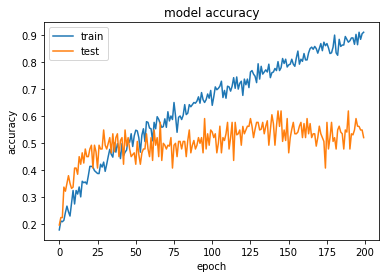

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now, let's visualizes changes in our loss over time.

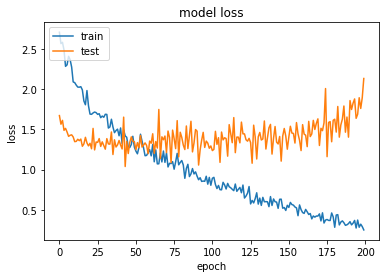

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Key Points
- Data Augmentation enables us to create valid perturbations of relatively small datasets to great effect
- Pre-Trained models provide an excellent starting point for acquiring completely distinct domain knowledge
- Dropout helps prevent overfitting
- **Nothing beats more data!**

## ToDo
- Buy a GPU :)